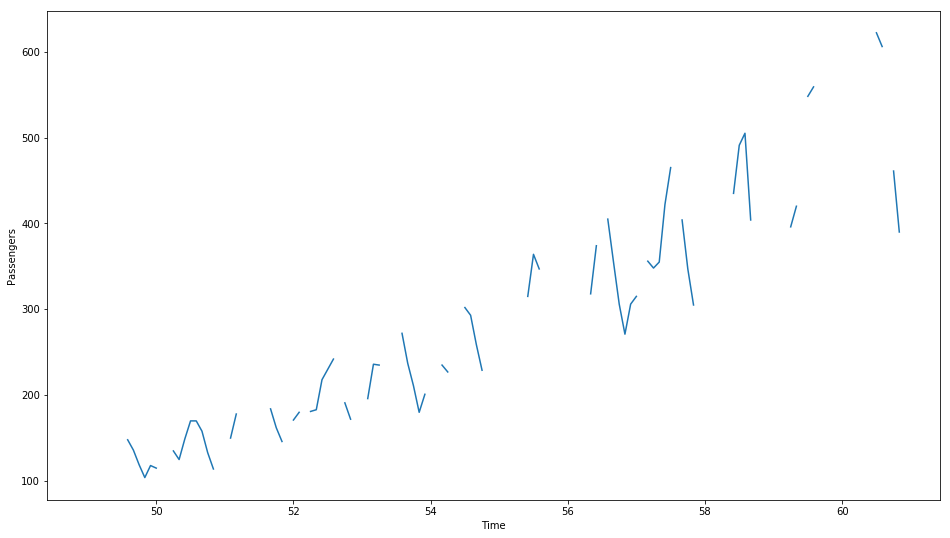

In [73]:
%matplotlib inline

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

csvfile = np.genfromtxt('flights.csv', delimiter=',')
T = csvfile[1:,0]
X = csvfile[1:,1]

plt.figure(figsize=(16,9))
plt.plot(T - 1900, X)
plt.xlabel('Time')
plt.ylabel('Passengers')
M = plt.show()

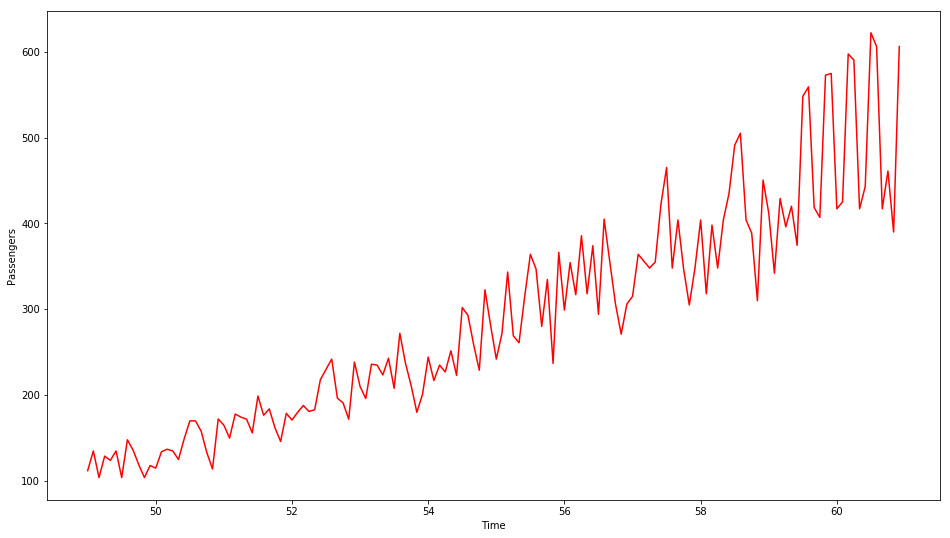

In [74]:
M = 4
# N is used as length of X instead of last index
# Note that it differs from N in pdf
N = len(X)

X_missing_mask = np.isnan(X)
X_observed_mask = ~X_missing_mask

index_arrays = [range(i+M, i, -1) for i in range(0,N-M)]
GX_index_transform = np.stack(index_arrays, axis=0)

GA_base = np.zeros((N-M, N))
GA_base[(range(0, N-M),range(M, N))] = -1

def build_GA(GA_, A_):
    for i in range(0, M):
        GA_[(range(0, N-M),range(i, N-M+i))] = A_[i]
    return GA_    

def least_square(A_, b_):
    U, d, VT = la.svd(A_)
    D = np.diag(d)
    D_pseudo_inverse = np.zeros(A_.shape).T
    D_pseudo_inverse[np.nonzero(D)] = 1/D[np.nonzero(D)]
    x_ = VT.T.dot(D_pseudo_inverse.dot(U.T.dot(b_)))
    return x_

# fill missing indexes with zero
X_processed = np.where(X_missing_mask, np.zeros(N), X)
A = np.zeros(M)

for j in range(0,400):
    X_m_to_n = X_processed[M:]
    GX = X_processed[GX_index_transform]
    A = least_square(GX, X_m_to_n)
    GA = build_GA(GA_base, A)
    GA_mising = GA[:,X_missing_mask]
    GA_observed = GA[:,X_observed_mask]
    X_observed = X_processed[X_observed_mask]
    X_missing = least_square(GA_mising, -1*GA_observed.dot(X_observed))
    X_processed[X_missing_mask] = X_missing

plt.figure(figsize=(16,9))
plt.plot(T - 1900, X_processed, color='red')
plt.xlabel('Time')
plt.ylabel('Passengers')
M = plt.show()



[  1.00000000e+00   7.38558776e-16  -3.30734865e-16  -1.17356658e-15]


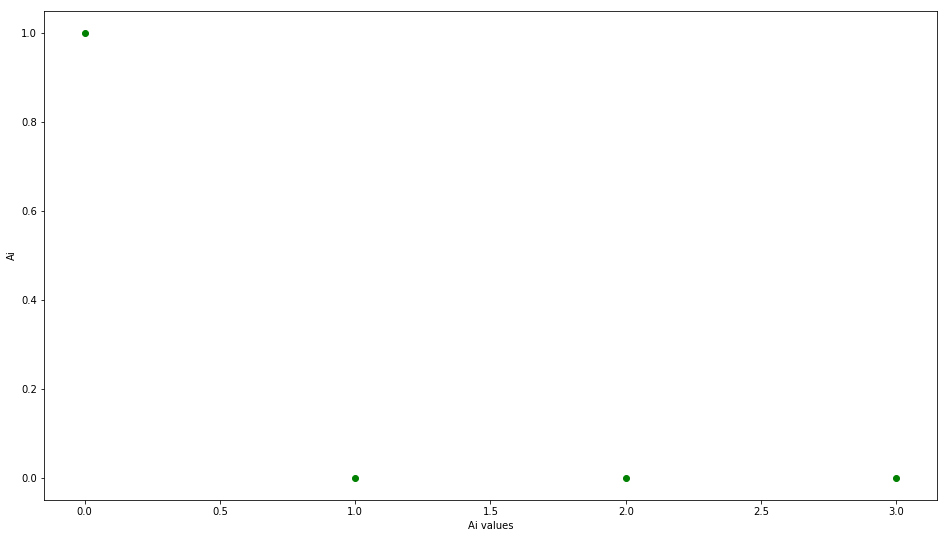

In [75]:
print(A)
plt.figure(figsize=(16,9))
plt.plot([0, 1, 2, 3], A, 'go')
plt.xlabel('Ai values')
plt.ylabel('Ai')
M = plt.show()

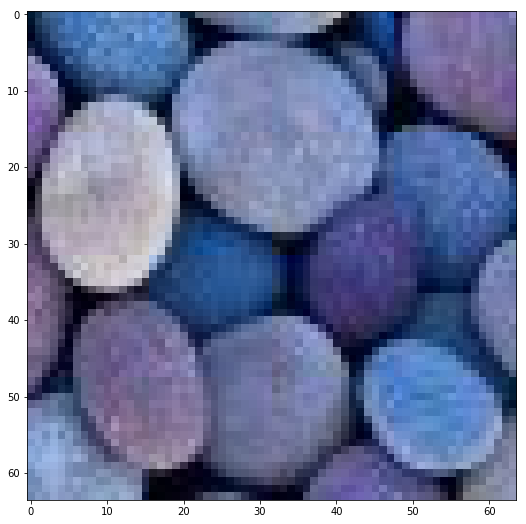

In [76]:
%matplotlib inline

import scipy as sc
from scipy.misc import imread

image = imread('stones_rgb.jpg')
plt.figure(figsize=(16,9))
plt.imshow(image)


In [77]:
h = 64
n = h**2

Lambda = np.array([[ .299,    .587,    .114],
              [-.14713, -.28886,  .436],
              [ .615,   -.51499, -.10001]])
r = 2
sigma = 10

def sim(ci_, cj_):
    return  np.exp((-1)*(np.sum((Lambda.dot(ci_-cj_))**2))/(2*sigma**2))

W = np.zeros((n,n))

# i and j are from 0 to n-1
# note that they differ from i and j in pdf
for i in range(0,n):
    for j in range(i+1,n):
        xi = i%h
        yi = i//h
        xj = j%h
        yj = j//h
        if i!=j and abs(xi - xj) <= r and abs(yi - yj) <= r:
            W[i, j] = sim(image[xi, yi], image[xj, yj])
            W[j, i] = W[i, j] #since j depends on i

In [78]:
# Laplacian matrix
d = np.sum(W, axis=1)
d2 = 1/np.sqrt(d)
D2 = np.diag(d2)
L = D2.dot(W.dot(D2))

In [81]:
# Eigenvectors
k = 5

Q, R = la.qr(np.random.randn(n,k))
for i in range(0,5000):
    Q, R = la.qr(L.dot(Q))
Q = L.dot(Q)

V = D2.dot(Q)

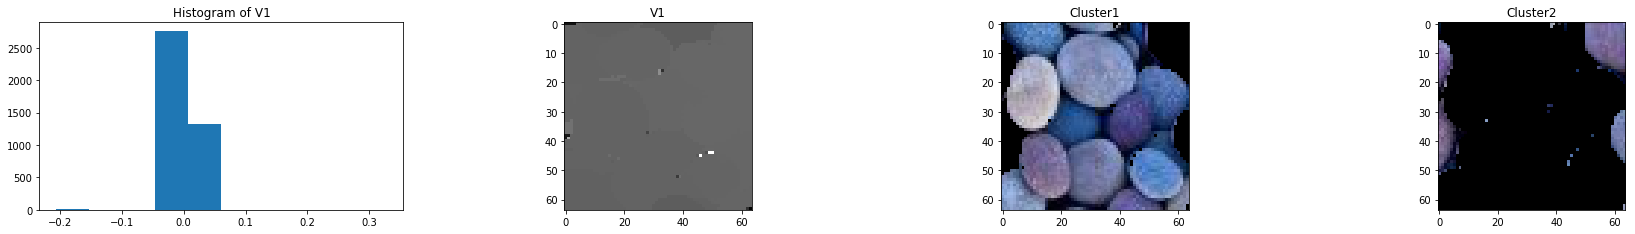

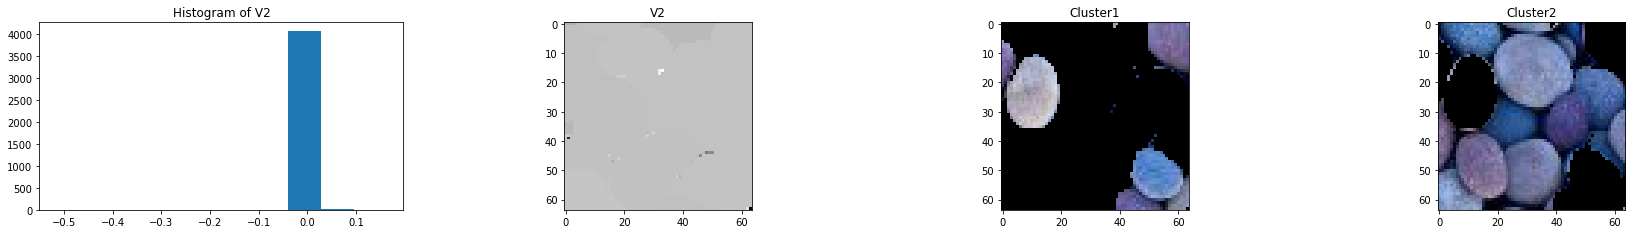

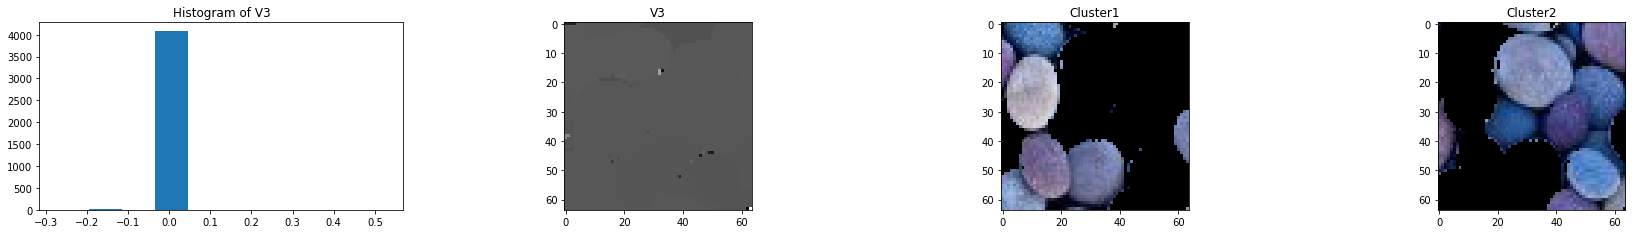

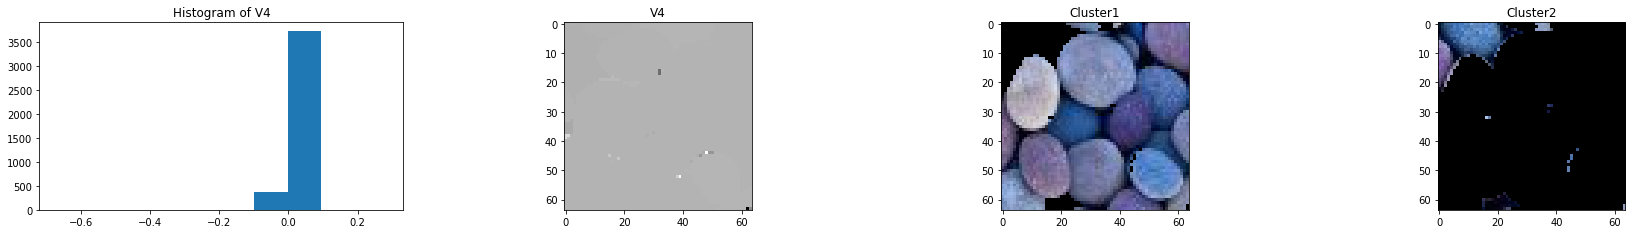

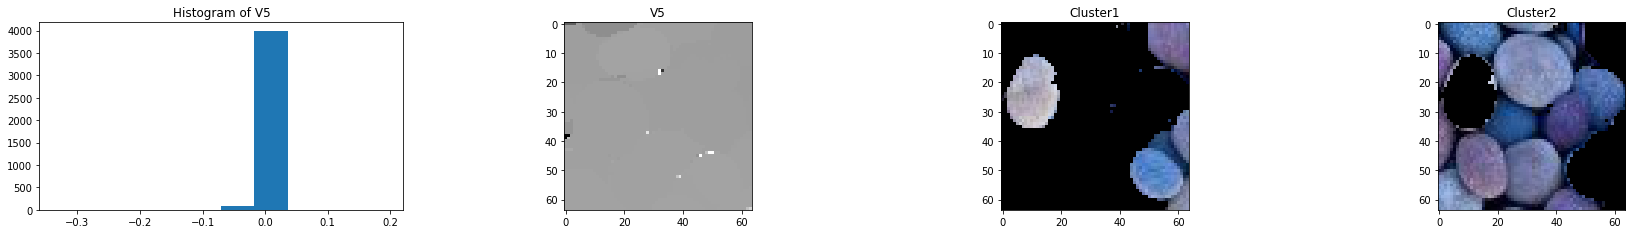

In [83]:
for i in range(0,k):
    plt.figure(figsize=(30,20))
    plt.subplot(k,4,i*4+1)
    plt.hist(V[:,i])
    plt.title('Histogram of V%d'%(i+1))
    plt.subplot(k,4,i*4+2)
    V_reshaped = V[:,i].reshape(h,h)
    plt.imshow(V_reshaped, cmap='gray')
    plt.title('V%d'%(i+1))
    
    C1 = image.copy()
    C2 = image.copy()
    for x in range(0, h):
        for y in range(0,h):
            if V_reshaped[y, x] < 0:
                C1[x, y] = 0
            else:
                C2[x, y] = 0
    plt.subplot(k,4,i*4+3)
    plt.imshow(C1)
    plt.title('Cluster1')
    plt.subplot(k,4,i*4+4)
    plt.imshow(C2)
    plt.title('Cluster2')
    
    

(64, 64)


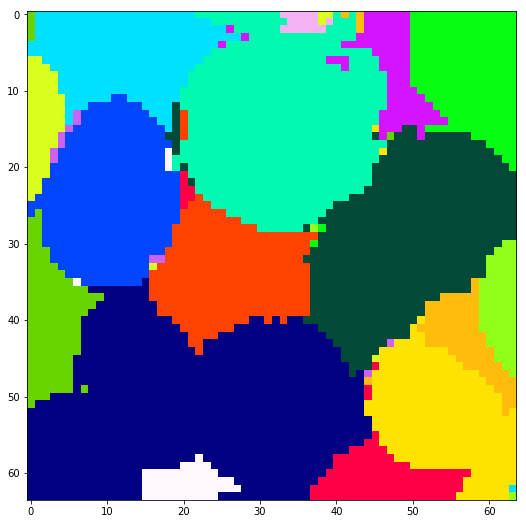

In [109]:
# Bonus Part

from sklearn.cluster import KMeans
from sklearn import cluster

V_norm1D = la.norm(V, axis=1)
V_norm = V/V_norm1D.reshape((V_norm1D.shape[0],1))

k_means = cluster.KMeans(n_clusters=17)
clusters = kms.fit_predict(V_norm).reshape((h,h)).T


print(clusters.shape)

plt.figure(figsize=(16,9))
plt.imshow(clusters,cmap='gist_ncar')
